## Resampling Sentinel-2 L2A data

In this tutorial, we'll learn how to resample the **Sentinel-2 L2A** data hosted in the [Planetary Computer Data Catalog](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a). In the process, we'll see how to:
- Access the Sentinel-2 L2A data with the Planetary Computer STAC API
- Search for a sample region and render the image
- Explore the Xarray-spatial utility function `resample` upsampling and downsampling the image  

The resampling operation is necessary when wanting a larger or small version of some image. In the case of a large version, it is called **Interpolation**, which can be done using the algorithm linear or nearest-neighbor. For a small version, it is called **Aggregation**, which can be used the algorithm mean, min, max, mode, and std (standard deviation).  

[Xarray-spatial](https://xarray-spatial.org/) provides a utility function to easily resample geospatial image data, which wraps [Datashader Canvas](https://datashader.org/api.html#datashader.Canvas).  

Some of the examples used in this tutorial were adapted from the [Datashader Grids User Guide](https://datashader.org/user_guide/Grids.html) and [Accessing Sentinel-2 L2A data with the Planetary Computer STAC API Example Notebook](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook).

### Accessing the Sentinel-2 L2A data

The [Planetary Computer STAC API](https://planetarycomputer.microsoft.com/docs/overview/about) works with or without an API key, but you will be given more permissive access to the data with an API key.

In [1]:
from pystac_client import Client
import planetary_computer as pc

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)

#### Choosing a region and time of interest

This area is near Jonah Bay, Alaska.

In [11]:
area_of_interest = {
    'type': 'Polygon',
    'coordinates': [
        [
            [-148.56536865234375,60.80072385643073],
            [-147.44338989257812,60.80072385643073],
            [-147.44338989257812,61.18363894915102],
            [-148.56536865234375,61.18363894915102],
            [-148.56536865234375,60.80072385643073]
        ]
    ],
}

Define the time range to filter images with. Here we use the summer of 2019.

In [12]:
time_of_interest = '2019-06-01/2019-08-01'

#### Searching the collection and choosing an image to render

Use [pystac-client](https://github.com/stac-utils/pystac-client) to search for Sentinel 2 L2A data in June of 2020.

In [13]:
catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')

search = catalog.search(
    collections=['sentinel-2-l2a'], 
    intersects=area_of_interest, 
    datetime=time_of_interest    
)
print(f'{search.matched()} Items found')

85 Items found


We can now work directly with the [PySTAC](https://github.com/stac-utils/pystac) Items returned by the API. Here we find the least cloudy of the bunch.

In [14]:
least_cloudy_item = sorted(search.items(), key=lambda item: item.ext.eo.cloud_cover)[0]

Get the URL to the 20m resolution visual [Cloud Optimized GeoTIFF](https://www.cogeo.org/) image.

In [15]:
asset_href = least_cloudy_item.assets['visual-20m'].href

This HREF is a URL is the location of the asset data on [Azure Blob Storage](https://azure.microsoft.com/en-us/services/storage/blobs/). In order to read the data, we'll need to retrieve a [Shared Access Signature](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview) and supply it as a query parameter. These tokens are generated from the Planetary Computer [Data Access API](https://planetarycomputer.microsoft.com/api/sas/v1/docs).

We use the [planetary-computer](https://github.com/microsoft/planetary-computer-sdk-for-python) package to **sign** our asset HREF with a generated token.

In [16]:
signed_href = pc.sign(asset_href)

We can now use the HREF to read our data in any tools that can retrieve data from URLs via HTTP GET operations.

#### Rendering the image

In [42]:
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image

In [46]:
with rasterio.open(signed_href) as data_prev:    
    aoi_bounds = features.bounds(area_of_interest)
    warped_aoi_bounds = warp.transform_bounds('epsg:4326', data_prev.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=data_prev.transform, *warped_aoi_bounds)
    band_data = data_prev.read(window=aoi_window)

rasterio gives us data band-interleave format; transpose to pixel interleave, and downscale the image data for plotting.

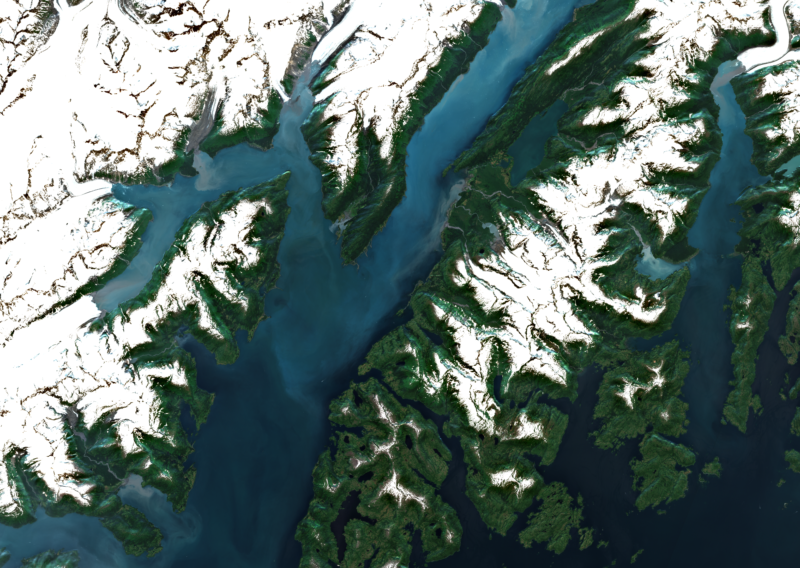

In [47]:
img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
w = img.size[0]; h = img.size[1]; aspect = w/h
target_w = 800; target_h = (int)(target_w/aspect)
img.resize((target_w,target_h),Image.BILINEAR)

### Resampling

In [41]:
import matplotlib.pyplot as plt
import xarray as xr
from xrspatial.utils import resample

In [18]:
img_arr = xr.open_rasterio(signed_href)

#### Interpolation (upsampling)

In [49]:
img_up_linear = resample(img_arr, height=6000, width=6000, interpolate='linear')
img_nearest_linear = resample(img_arr, height=6000, width=6000, interpolate='nearest')

Text(0.5, 1.0, 'nearest-neighbor interpolation')

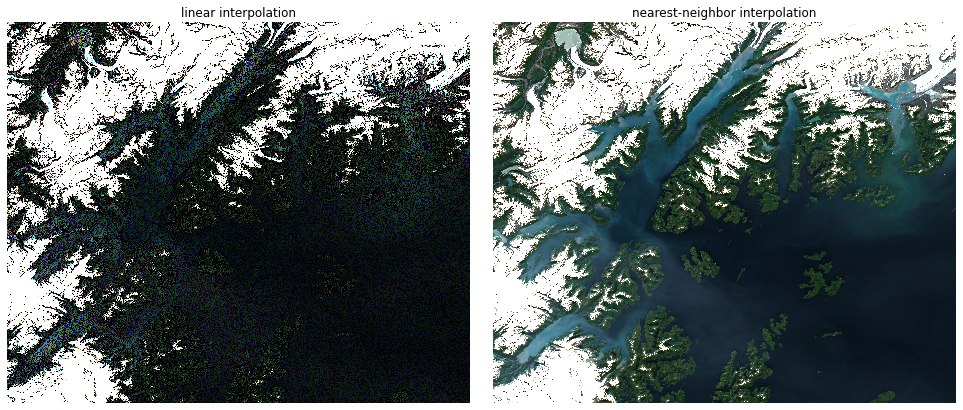

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7))
plt.subplots_adjust(wspace=0.05)

for i in range(0, 2):
    ax[i].set_axis_off()

img_up_linear.plot.imshow(ax=ax[0])
img_nearest_linear.plot.imshow(ax=ax[1])

ax[0].set_title('linear interpolation')
ax[1].set_title('nearest-neighbor interpolation')

#### Aggregation (downsampling)

In [51]:
img_down_mean = resample(img_arr, height=500, width=500, agg='mean')
img_down_min = resample(img_arr, height=500, width=500, agg='min')
img_down_max = resample(img_arr, height=500, width=500, agg='max')
img_down_mode = resample(img_arr, height=500, width=500, agg='mode')
img_down_std = resample(img_arr, height=500, width=500, agg='std')

Text(0.5, 1.0, 'std downsampling')

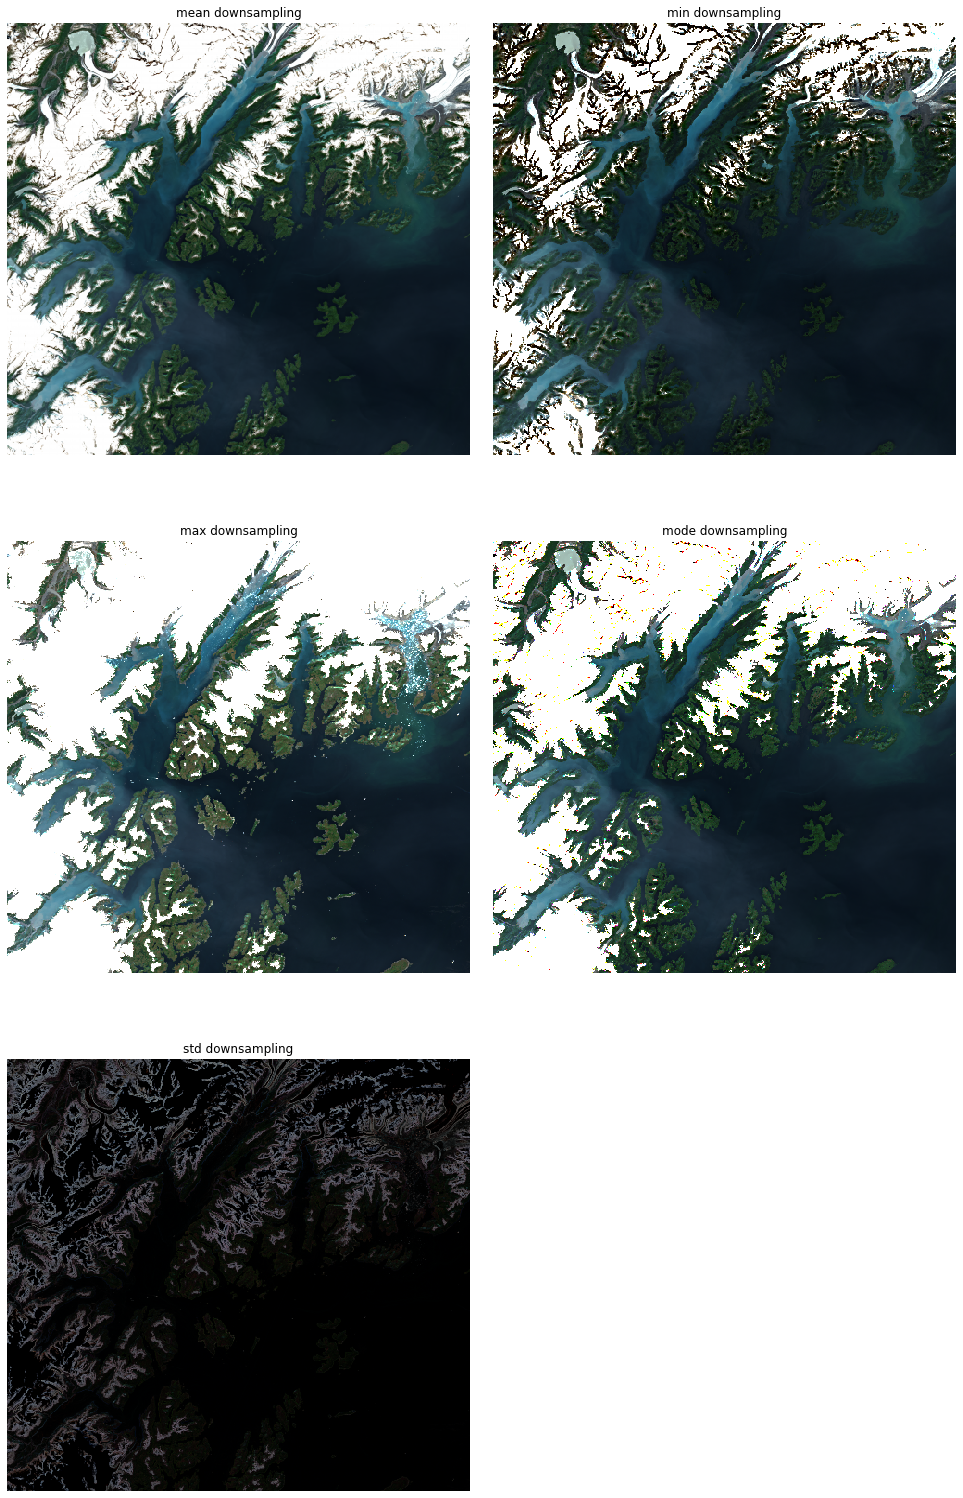

In [62]:
fig, ax = plt.subplots(3, 2, figsize=(17, 27))
plt.subplots_adjust(wspace=0.05)

for i in range(0, 3):
    for j in range(0, 2):
        ax[i][j].set_axis_off()

img_down_mean.plot.imshow(ax=ax[0][0])
img_down_min.plot.imshow(ax=ax[0][1])
img_down_max.plot.imshow(ax=ax[1][0])
img_down_mode.plot.imshow(ax=ax[1][1])
img_down_std.plot.imshow(ax=ax[2][0])


ax[0][0].set_title('mean downsampling')
ax[0][1].set_title('min downsampling')
ax[1][0].set_title('max downsampling')
ax[1][1].set_title('mode downsampling')
ax[2][0].set_title('std downsampling')